# Halo Data and Healpy

I've built a class (<code>halo.py</code>) to load halo data.

In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from halo import HaloCatalog, HaloCatalogManager

In [2]:
# Parameters for maps and catalogs
nside = 128  
npix = hp.nside2npix(nside)

## Exercise 3

In [3]:
#-------------------- CONVERGENCE MAP ----------------------

# Load the CMB convergence map at redshift 0.5 and downgrade it to match the halo map nside
map_file = 'KappaMap_snap_048.DM.seed_100672.fits'
print("Reading KappaMap_snap_048.DM.seed_100672.fits")
cmb_map = hp.read_map(map_file)
cmb_map_downgraded = hp.ud_grade(cmb_map, nside)

Reading KappaMap_snap_048.DM.seed_100672.fits


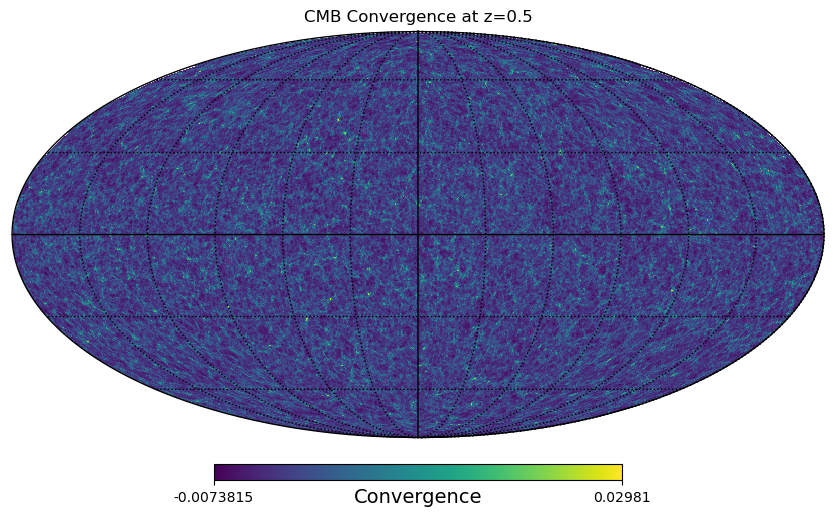

In [4]:
# Display the downgraded CMB convergence map
hp.mollview(cmb_map_downgraded, title="CMB Convergence at z=0.5", unit="Convergence")
hp.graticule()

## Exercises 5

Reading AllSkyMock_snap_048_0.bin0
Reading AllSkyMock_snap_048_1.bin0
Reading AllSkyMock_snap_048_2.bin0
Reading AllSkyMock_snap_048_3.bin0


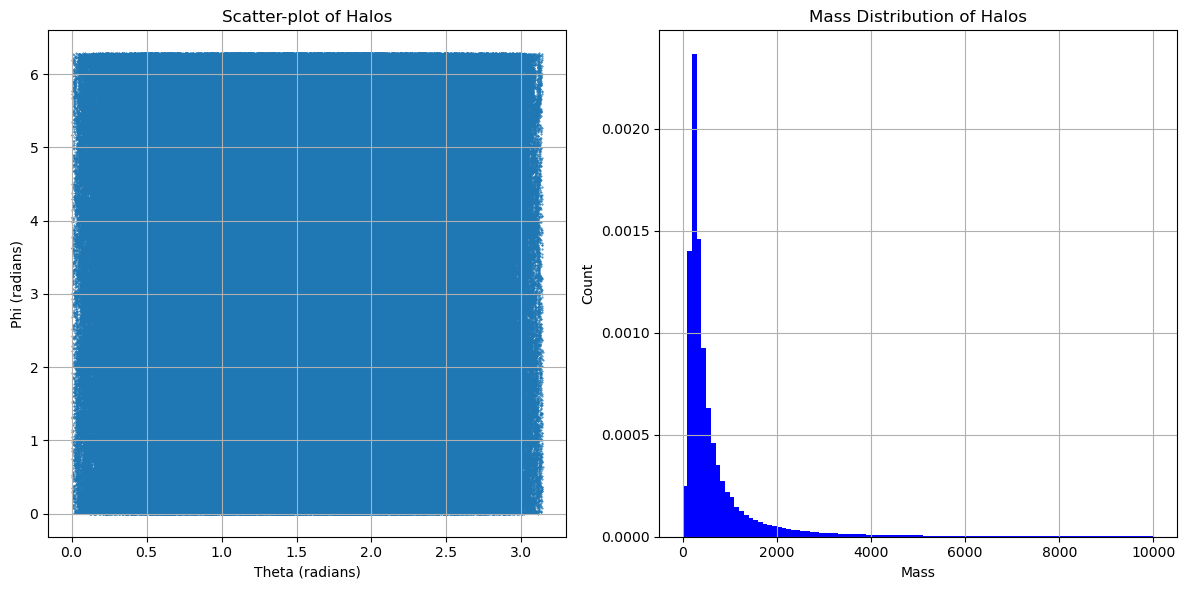

In [5]:
snapshot_number = 48
halos = HaloCatalog(snapshot_number)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(halos.theta, halos.phi, s=0.2)
plt.title('Scatter-plot of Halos')
plt.xlabel('Theta (radians)')
plt.ylabel('Phi (radians)')
plt.grid()

plt.subplot(1, 2, 2)
plt.hist(halos.mass, bins=100, color='blue', density=True, range=(0, 1e4))
plt.title('Mass Distribution of Halos')
plt.xlabel('Mass')
plt.ylabel('Count')
plt.grid()

plt.tight_layout()
plt.show()

## Exercises 6

In [6]:
#---------------------- HALO CATALOGS ----------------------

# Select halo catalogs with z < 0.5 and initialize the manager
snapshot_numbers = range(48, 62)
manager = HaloCatalogManager(snapshot_numbers)

# Set a mass threshold and apply a filter to halos
mass_threshold = 1e2
filtered_manager = manager.select_mass_above(mass_threshold)

# Retrieve the angular coordinates of halos and convert them into pixel indices
theta = np.concatenate(filtered_manager.theta)
phi = np.concatenate(filtered_manager.phi)
pix_indices = hp.ang2pix(nside, theta, phi)

# Count the number of halos in each pixel
halo_map = np.zeros(npix)
for pix in pix_indices:
    halo_map[pix] += 1

Reading AllSkyMock_snap_048_0.bin0
Reading AllSkyMock_snap_048_1.bin0
Reading AllSkyMock_snap_048_2.bin0
Reading AllSkyMock_snap_048_3.bin0
Reading AllSkyMock_snap_049_0.bin0
Reading AllSkyMock_snap_049_1.bin0
Reading AllSkyMock_snap_049_2.bin0
Reading AllSkyMock_snap_049_3.bin0
Reading AllSkyMock_snap_050_0.bin0
Reading AllSkyMock_snap_050_1.bin0
Reading AllSkyMock_snap_050_2.bin0
Reading AllSkyMock_snap_050_3.bin0
Reading AllSkyMock_snap_051_0.bin0
Reading AllSkyMock_snap_051_1.bin0
Reading AllSkyMock_snap_051_2.bin0
Reading AllSkyMock_snap_051_3.bin0
Reading AllSkyMock_snap_052_0.bin0
Reading AllSkyMock_snap_052_1.bin0
Reading AllSkyMock_snap_052_2.bin0
Reading AllSkyMock_snap_052_3.bin0
Reading AllSkyMock_snap_053_0.bin0
Reading AllSkyMock_snap_053_1.bin0
Reading AllSkyMock_snap_053_2.bin0
Reading AllSkyMock_snap_053_3.bin0
Reading AllSkyMock_snap_054_0.bin0
Reading AllSkyMock_snap_054_1.bin0
Reading AllSkyMock_snap_054_2.bin0
Reading AllSkyMock_snap_054_3.bin0
Reading AllSkyMock_s

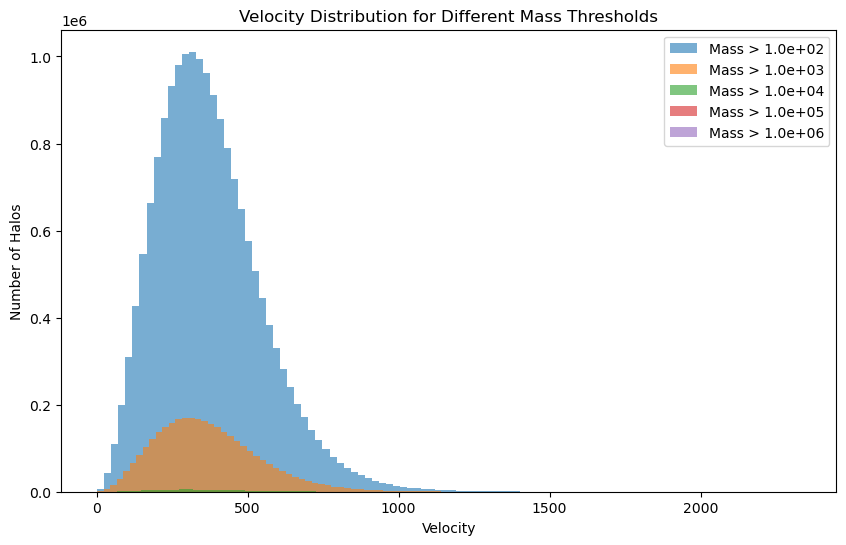

In [7]:
mass_thresholds = [1e2, 1e3, 1e4, 1e5, 1e6] 
velocity_distributions = []

for threshold in mass_thresholds:
    filtered_manager = manager.select_mass_above(threshold)
    velocities = filtered_manager.calculate_velocity()
    combined_velocities = np.concatenate(velocities)
    velocity_distributions.append(combined_velocities)

# Plot 
plt.figure(figsize=(10, 6))

for velocities, threshold in zip(velocity_distributions, mass_thresholds):
    plt.hist(velocities, bins=100, alpha=0.6, label=f'Mass > {threshold:.1e}')

plt.xlabel('Velocity')
plt.ylabel('Number of Halos')
plt.title('Velocity Distribution for Different Mass Thresholds')
plt.legend()
plt.show()

## Exercise 7

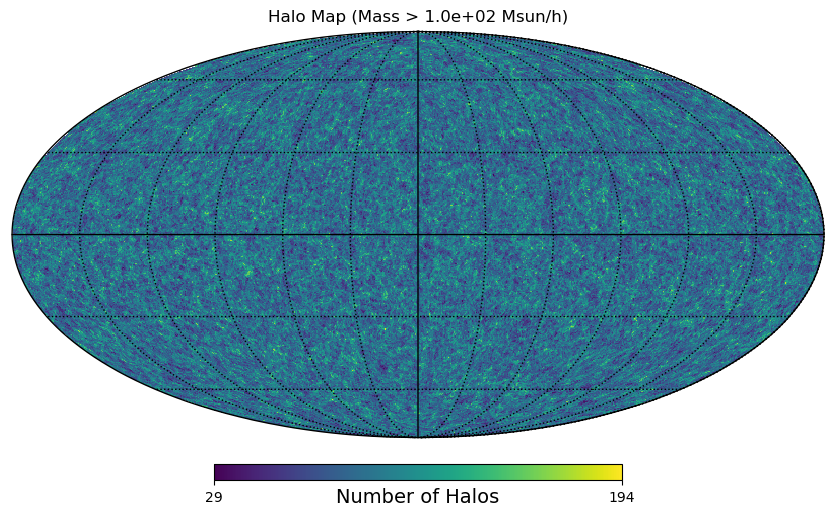

In [8]:
# Display the halo map
hp.mollview(halo_map, title=f'Halo Map (Mass > {mass_threshold:.1e} Msun/h)', unit='Number of Halos')
hp.graticule()

## Exercise 8

In [9]:
#------------------ CROSS CORRELATION ----------------------

# Compute the cross-correlation between the halo map and the downgraded CMB convergence map
cross_correlation = hp.anafast(halo_map, cmb_map_downgraded)

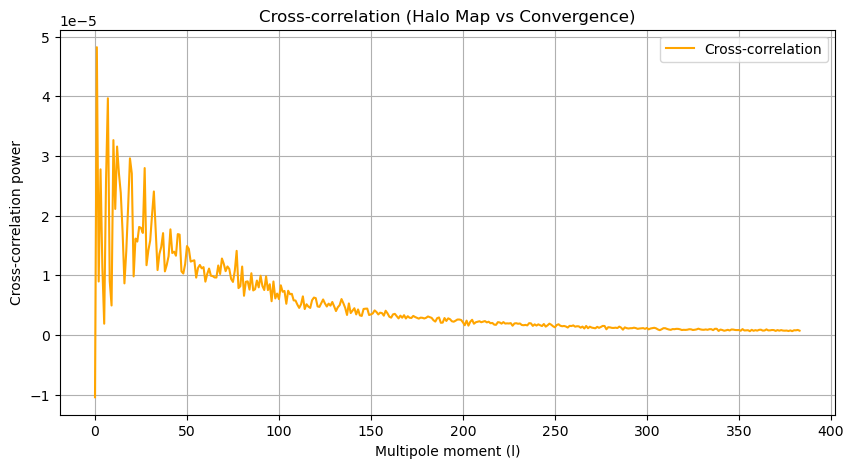

In [10]:
# Plot the cross-correlation power spectrum
l = np.arange(len(cross_correlation))
plt.figure(figsize=(10, 5))
plt.plot(l, cross_correlation, label='Cross-correlation', color='orange')
plt.xlabel('Multipole moment (l)')
plt.ylabel('Cross-correlation power')
plt.title('Cross-correlation (Halo Map vs Convergence)')
plt.legend()
plt.grid()

## Exercise 9

In [11]:
#------------------ LENSING POTENTIAL ----------------------

######################### FUNCTIONS ##########################

# Solve the equation for the lensing potential: ∇² ψ = 2 κ
# In Fourier space, l(l+1) ψ_{lm} = 2 κ_{lm}
# Thus, ψ_{lm} =  2 κ_{lm} / [l(l+1)]

# Calculate the lensing potential (psi) from the convergence map
def calculate_lensing_potential(kappa_map):
    
    # Set lmax and transform the kappa_map into spherical harmonics
    lmax = 2 * nside + 1
    kappa_alm = hp.map2alm(kappa_map, lmax=lmax)

    # For each l and m, 
    # calculate the corresponding psi_{lm} by multiplying κ_{lm} * 2 / [l(l+1)]
    # 1. l = 0 is excluded since it is in the denominator
    # 2. healpy uses only m > 0
    psi_alm = np.zeros_like(kappa_alm, dtype=complex)
    for l in range(1, lmax + 1): 
        factor = 2 / (l * (l + 1))
        for m in range(l + 1):
            index = hp.Alm.getidx(lmax, l, m)
            psi_alm[index] = factor * kappa_alm[index]

    # Transform psi_{lm} back into real space to get psi_map
    return hp.alm2map(psi_alm, nside=nside, lmax=lmax)

#############################################################

# Calculate the lensing potential
lensing_potential = calculate_lensing_potential(cmb_map_downgraded)

# Compute the cross-correlation between the halo map and the lensing potential map
cross_correlation = hp.anafast(halo_map, lensing_potential)

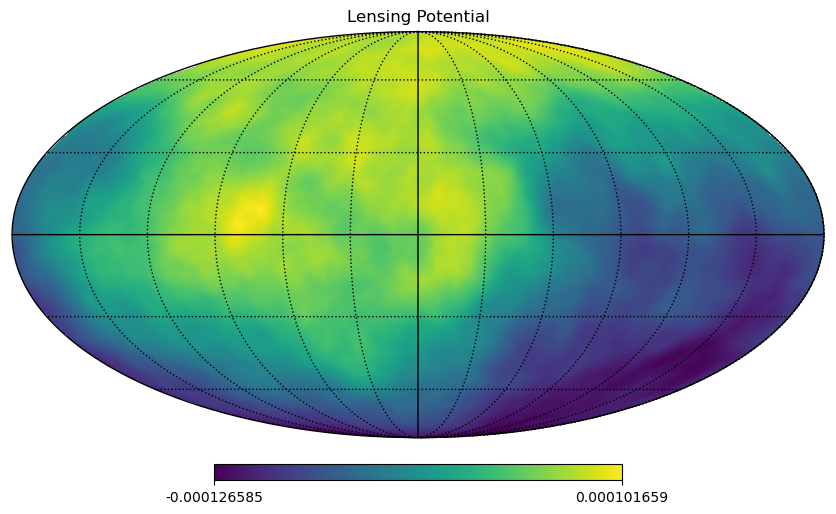

In [12]:
# Display the lensing potential map
hp.mollview(lensing_potential, title='Lensing Potential')
hp.graticule()
plt.show()

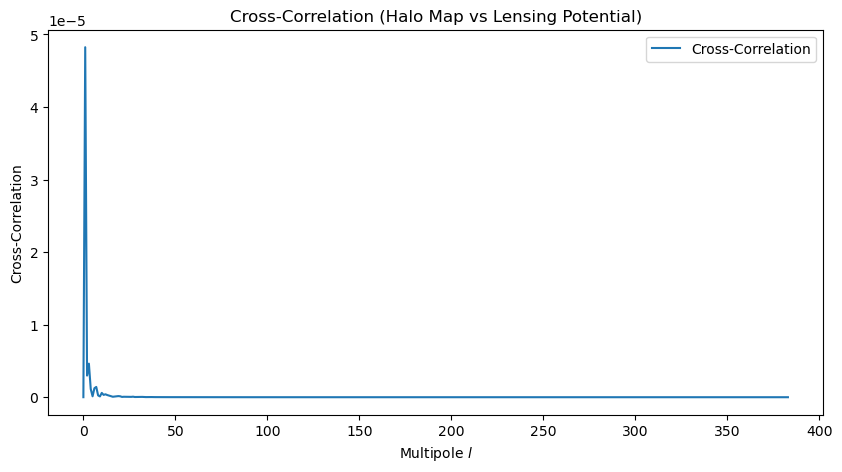

In [13]:
# Plot the cross-correlation between the halo map and lensing potential
l = np.arange(len(cross_correlation))
plt.figure(figsize=(10, 5))
plt.plot(l, cross_correlation, label='Cross-Correlation')
plt.xlabel(r'Multipole $l$')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation (Halo Map vs Lensing Potential)')
plt.legend()
plt.show()